<a id="0"></a>
<p style="background-color:#281F2F;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;">~ ~ ~ ~ Libraries ~ ~ ~ ~</p>

In [ ]:
!pip install ../input/torchlibrosa/torchlibrosa-0.0.5-py3-none-any.whl > /dev/null

In [ ]:
!pip install  ../input/wheat-head-detection-packages/timm-0.5.4-py3-none-any.whl

In [ ]:
# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import random # for torch seed
from tqdm import tqdm
import json

from pathlib import Path
import warnings
from contextlib import contextmanager
from typing import List
from typing import Optional
import logging

# audio
import librosa
import soundfile as sf
from torchlibrosa.stft import LogmelFilterBank, Spectrogram
from torchlibrosa.augmentation import SpecAugmentation
import torchaudio

# sklearn
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, GroupKFold

# torch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as torchdata
from torch.optim import Adam, AdamW, RMSprop # optmizers
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau # Learning rate schedulers
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2


# albumentations
# from albumentations.core.transforms_interface import ImageOnlyTransform
import albumentations as A
import albumentations.pytorch.transforms as T

# timm
import sys
#sys.path.append('../input/../input/timmmaster')
import timm

print("Timm version: ", timm.__version__)
print("Librosa version: ", librosa.__version__)
print("Albumentations version: ", A.__version__)

<a id="1"></a>
# <p style="background-color:#281F2F;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;">~ ~ ~ ~ Introduction ~ ~ ~ ~</p>

This notebook implements the final Ensemble pipeline developed for the BirdCLEF 2022 competition where our team achieve the Bronze medal in 65th position. 

We had two big challenges to carry out the ensemble:

- 1 Inference kernel timeout
- 2 Tuning the contribution of each backbones 

For solve de problem 1 we merge all checkpoints into a single Ensemble class, with this it was possible to make inference for all models in one loop of test dataloader.

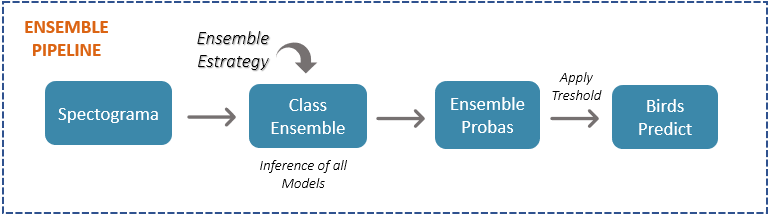


To solve problem 2 we implement two strategies of ensemble , the first is the simple global average of the checkpoints and the second is the weighted sum of the averages of each backbone.


*backbone(n):* $\frac{1}{Nfolds}\sum_{0}^{n} fold({n})$

*Global average* : $\frac{\sum_{0}^{n} backbone(n)}{Nbackbones} $

*Wheighted sum*: $\sum_{0}^{n} backbone(n)*W(n)$

Where $W(n)$ is wheight of contribution for $backbone(n)$.

This process is done for each spectogram of each audio in the test database,if you want seen the impleentation in code jump to [here](#ensemble_class).

In order for our team solution uses two backbones with five folds each, totaling 10 checkpints. With this pipeline this inference took approximately 5h.

# Master CFG

In [ ]:
class CFG:
          DEBUG = False # True # False
        
          EXP_ID = 'N001'

          N_CLASS = 152 # len(np.unique(train['primary_label']))
          target_columns = 'afrsil1 akekee akepa1 akiapo akikik amewig aniani apapan arcter \
                      barpet bcnher belkin1 bkbplo bknsti bkwpet blkfra blknod bongul \
                      brant brnboo brnnod brnowl brtcur bubsan buffle bulpet burpar buwtea \
                      cacgoo1 calqua cangoo canvas caster1 categr chbsan chemun chukar cintea \
                      comgal1 commyn compea comsan comwax coopet crehon dunlin elepai ercfra eurwig \
                      fragul gadwal gamqua glwgul gnwtea golphe grbher3 grefri gresca gryfra gwfgoo \
                      hawama hawcoo hawcre hawgoo hawhaw hawpet1 hoomer houfin houspa hudgod iiwi incter1 \
                      jabwar japqua kalphe kauama laugul layalb lcspet leasan leater1 lessca lesyel lobdow lotjae \
                      madpet magpet1 mallar3 masboo mauala maupar merlin mitpar moudov norcar norhar2 normoc norpin \
                      norsho nutman oahama omao osprey pagplo palila parjae pecsan peflov perfal pibgre pomjae puaioh \
                      reccar redava redjun redpha1 refboo rempar rettro ribgul rinduc rinphe rocpig rorpar rudtur ruff \
                      saffin sander semplo sheowl shtsan skylar snogoo sooshe sooter1 sopsku1 sora spodov sposan \
                      towsol wantat1 warwhe1 wesmea wessan wetshe whfibi whiter whttro wiltur yebcar yefcan zebdov'.split()

          random_seed = 42

# CFGs for Backbone 1

In [ ]:
class CFG_01:
    DEBUG = False 
    EXP_ID = 'N001'   
    IMG_HEIGHT = 256  
    IMG_WIDTH = 313
    IN_CHANS = 3  
    N_CLASS = 152 
    target_columns = 'afrsil1 akekee akepa1 akiapo akikik amewig aniani apapan arcter \
                  barpet bcnher belkin1 bkbplo bknsti bkwpet blkfra blknod bongul \
                  brant brnboo brnnod brnowl brtcur bubsan buffle bulpet burpar buwtea \
                  cacgoo1 calqua cangoo canvas caster1 categr chbsan chemun chukar cintea \
                  comgal1 commyn compea comsan comwax coopet crehon dunlin elepai ercfra eurwig \
                  fragul gadwal gamqua glwgul gnwtea golphe grbher3 grefri gresca gryfra gwfgoo \
                  hawama hawcoo hawcre hawgoo hawhaw hawpet1 hoomer houfin houspa hudgod iiwi incter1 \
                  jabwar japqua kalphe kauama laugul layalb lcspet leasan leater1 lessca lesyel lobdow lotjae \
                  madpet magpet1 mallar3 masboo mauala maupar merlin mitpar moudov norcar norhar2 normoc norpin \
                  norsho nutman oahama omao osprey pagplo palila parjae pecsan peflov perfal pibgre pomjae puaioh \
                  reccar redava redjun redpha1 refboo rempar rettro ribgul rinduc rinphe rocpig rorpar rudtur ruff \
                  saffin sander semplo sheowl shtsan skylar snogoo sooshe sooter1 sopsku1 sora spodov sposan \
                  towsol wantat1 warwhe1 wesmea wessan wetshe whfibi whiter whttro wiltur yebcar yefcan zebdov'.split()

    random_seed = 42
    ### model
    model_name = 'seresnext26tn_32x4d'
    
    period = 5
    n_mels = 128 
    fmin = 20
    fmax = 16000
    n_fft = 2048
    hop_length = 512
    sample_rate = 32000
    melspectrogram_parameters = {
            "n_mels": 128, 
            "fmin": 20,
            "fmax": 16000
    }
    
    loader_params = {
    "train": {
        "batch_size": 3,  
        "num_workers": 0,
        "shuffle": True
    },
    "valid": {
        "batch_size": 64, 
        "num_workers": 0,
        "shuffle": False
    }
    }
    
    
class CFG_02:

    DEBUG = False 
    EXP_ID = 'N001'
    IMG_HEIGHT = 256  
    IMG_WIDTH = 313
    IN_CHANS = 3  
    N_CLASS = 152 
    target_columns = 'afrsil1 akekee akepa1 akiapo akikik amewig aniani apapan arcter \
                  barpet bcnher belkin1 bkbplo bknsti bkwpet blkfra blknod bongul \
                  brant brnboo brnnod brnowl brtcur bubsan buffle bulpet burpar buwtea \
                  cacgoo1 calqua cangoo canvas caster1 categr chbsan chemun chukar cintea \
                  comgal1 commyn compea comsan comwax coopet crehon dunlin elepai ercfra eurwig \
                  fragul gadwal gamqua glwgul gnwtea golphe grbher3 grefri gresca gryfra gwfgoo \
                  hawama hawcoo hawcre hawgoo hawhaw hawpet1 hoomer houfin houspa hudgod iiwi incter1 \
                  jabwar japqua kalphe kauama laugul layalb lcspet leasan leater1 lessca lesyel lobdow lotjae \
                  madpet magpet1 mallar3 masboo mauala maupar merlin mitpar moudov norcar norhar2 normoc norpin \
                  norsho nutman oahama omao osprey pagplo palila parjae pecsan peflov perfal pibgre pomjae puaioh \
                  reccar redava redjun redpha1 refboo rempar rettro ribgul rinduc rinphe rocpig rorpar rudtur ruff \
                  saffin sander semplo sheowl shtsan skylar snogoo sooshe sooter1 sopsku1 sora spodov sposan \
                  towsol wantat1 warwhe1 wesmea wessan wetshe whfibi whiter whttro wiltur yebcar yefcan zebdov'.split()

    random_seed = 42
    ### model
    model_name = 'seresnext26tn_32x4d'
    period = 5
    n_mels = 128 
    fmin = 20
    fmax = 16000
    n_fft = 2048
    hop_length = 512
    sample_rate = 32000
    melspectrogram_parameters = {
            "n_mels": 128,
            "fmin": 20,
            "fmax": 16000
    }
    
    loader_params = {
    "train": {
        "batch_size": 3,  
        "num_workers": 0,
        "shuffle": True
    },
    "valid": {
        "batch_size": 64, 
        "num_workers": 0,
        "shuffle": False
    }
    }
    
    
class CFG_03:

    DEBUG = False 

    EXP_ID = 'N001'
    
    IMG_HEIGHT = 256  
    IMG_WIDTH = 313
    IN_CHANS = 3  
    N_CLASS = 152 
    target_columns = 'afrsil1 akekee akepa1 akiapo akikik amewig aniani apapan arcter \
                  barpet bcnher belkin1 bkbplo bknsti bkwpet blkfra blknod bongul \
                  brant brnboo brnnod brnowl brtcur bubsan buffle bulpet burpar buwtea \
                  cacgoo1 calqua cangoo canvas caster1 categr chbsan chemun chukar cintea \
                  comgal1 commyn compea comsan comwax coopet crehon dunlin elepai ercfra eurwig \
                  fragul gadwal gamqua glwgul gnwtea golphe grbher3 grefri gresca gryfra gwfgoo \
                  hawama hawcoo hawcre hawgoo hawhaw hawpet1 hoomer houfin houspa hudgod iiwi incter1 \
                  jabwar japqua kalphe kauama laugul layalb lcspet leasan leater1 lessca lesyel lobdow lotjae \
                  madpet magpet1 mallar3 masboo mauala maupar merlin mitpar moudov norcar norhar2 normoc norpin \
                  norsho nutman oahama omao osprey pagplo palila parjae pecsan peflov perfal pibgre pomjae puaioh \
                  reccar redava redjun redpha1 refboo rempar rettro ribgul rinduc rinphe rocpig rorpar rudtur ruff \
                  saffin sander semplo sheowl shtsan skylar snogoo sooshe sooter1 sopsku1 sora spodov sposan \
                  towsol wantat1 warwhe1 wesmea wessan wetshe whfibi whiter whttro wiltur yebcar yefcan zebdov'.split()

    random_seed = 42
    model_name = 'seresnext26tn_32x4d'
    
    
    period = 5
    n_mels = 128 # 256 # 224
    fmin = 20
    fmax = 16000
    n_fft = 2048
    hop_length = 512
    sample_rate = 32000
    melspectrogram_parameters = {
            "n_mels": 128, 
            "fmin": 20,
            "fmax": 16000
    }
    
    loader_params = {
    "train": {
        "batch_size": 3,  
        "num_workers": 0,
        "shuffle": True
    },
    "valid": {
        "batch_size": 64, 
        "num_workers": 0,
        "shuffle": False
    }
    }
    
class CFG_04:

    DEBUG = False 

    EXP_ID = 'N001'
    
    IMG_HEIGHT = 256  
    IMG_WIDTH = 313
    IN_CHANS = 3  
    N_CLASS = 152 
    target_columns = 'afrsil1 akekee akepa1 akiapo akikik amewig aniani apapan arcter \
                  barpet bcnher belkin1 bkbplo bknsti bkwpet blkfra blknod bongul \
                  brant brnboo brnnod brnowl brtcur bubsan buffle bulpet burpar buwtea \
                  cacgoo1 calqua cangoo canvas caster1 categr chbsan chemun chukar cintea \
                  comgal1 commyn compea comsan comwax coopet crehon dunlin elepai ercfra eurwig \
                  fragul gadwal gamqua glwgul gnwtea golphe grbher3 grefri gresca gryfra gwfgoo \
                  hawama hawcoo hawcre hawgoo hawhaw hawpet1 hoomer houfin houspa hudgod iiwi incter1 \
                  jabwar japqua kalphe kauama laugul layalb lcspet leasan leater1 lessca lesyel lobdow lotjae \
                  madpet magpet1 mallar3 masboo mauala maupar merlin mitpar moudov norcar norhar2 normoc norpin \
                  norsho nutman oahama omao osprey pagplo palila parjae pecsan peflov perfal pibgre pomjae puaioh \
                  reccar redava redjun redpha1 refboo rempar rettro ribgul rinduc rinphe rocpig rorpar rudtur ruff \
                  saffin sander semplo sheowl shtsan skylar snogoo sooshe sooter1 sopsku1 sora spodov sposan \
                  towsol wantat1 warwhe1 wesmea wessan wetshe whfibi whiter whttro wiltur yebcar yefcan zebdov'.split()

    random_seed = 42
    ### model
    model_name = 'seresnext26tn_32x4d'
    period = 5
    n_mels = 128 
    fmin = 20
    fmax = 16000
    n_fft = 2048
    hop_length = 512
    sample_rate = 32000
    melspectrogram_parameters = {
            "n_mels": 128, 
            "fmin": 20,
            "fmax": 16000
    }
    
    loader_params = {
    "train": {
        "batch_size": 3,  
        "num_workers": 0,
        "shuffle": True
    },
    "valid": {
        "batch_size": 64, 
        "num_workers": 0,
        "shuffle": False
    }
    }
    
class CFG_05:

    DEBUG = False 
    EXP_ID = 'N001'
    IMG_HEIGHT = 256  
    IMG_WIDTH = 313
    IN_CHANS = 3  
    N_CLASS = 152 
    target_columns = 'afrsil1 akekee akepa1 akiapo akikik amewig aniani apapan arcter \
                  barpet bcnher belkin1 bkbplo bknsti bkwpet blkfra blknod bongul \
                  brant brnboo brnnod brnowl brtcur bubsan buffle bulpet burpar buwtea \
                  cacgoo1 calqua cangoo canvas caster1 categr chbsan chemun chukar cintea \
                  comgal1 commyn compea comsan comwax coopet crehon dunlin elepai ercfra eurwig \
                  fragul gadwal gamqua glwgul gnwtea golphe grbher3 grefri gresca gryfra gwfgoo \
                  hawama hawcoo hawcre hawgoo hawhaw hawpet1 hoomer houfin houspa hudgod iiwi incter1 \
                  jabwar japqua kalphe kauama laugul layalb lcspet leasan leater1 lessca lesyel lobdow lotjae \
                  madpet magpet1 mallar3 masboo mauala maupar merlin mitpar moudov norcar norhar2 normoc norpin \
                  norsho nutman oahama omao osprey pagplo palila parjae pecsan peflov perfal pibgre pomjae puaioh \
                  reccar redava redjun redpha1 refboo rempar rettro ribgul rinduc rinphe rocpig rorpar rudtur ruff \
                  saffin sander semplo sheowl shtsan skylar snogoo sooshe sooter1 sopsku1 sora spodov sposan \
                  towsol wantat1 warwhe1 wesmea wessan wetshe whfibi whiter whttro wiltur yebcar yefcan zebdov'.split()

    random_seed = 42
    model_name = 'seresnext26tn_32x4d'
    period = 5
    n_mels = 128 
    fmin = 20
    fmax = 16000
    n_fft = 2048
    hop_length = 512
    sample_rate = 32000
    melspectrogram_parameters = {
            "n_mels": 128, 
            "fmin": 20,
            "fmax": 16000
    }
    
    loader_params = {
    "train": {
        "batch_size": 3,  
        "num_workers": 0,
        "shuffle": True
    },
    "valid": {
        "batch_size": 64, 
        "num_workers": 0,
        "shuffle": False
    }
    }

# CFGs for Backbone 2

In [ ]:
class CFG_06:

    DEBUG = False 

    EXP_ID = 'N001'
    
    IMG_HEIGHT = 256  
    IMG_WIDTH = 313
    IN_CHANS = 3  
    N_CLASS = 152 
    target_columns = 'afrsil1 akekee akepa1 akiapo akikik amewig aniani apapan arcter \
                  barpet bcnher belkin1 bkbplo bknsti bkwpet blkfra blknod bongul \
                  brant brnboo brnnod brnowl brtcur bubsan buffle bulpet burpar buwtea \
                  cacgoo1 calqua cangoo canvas caster1 categr chbsan chemun chukar cintea \
                  comgal1 commyn compea comsan comwax coopet crehon dunlin elepai ercfra eurwig \
                  fragul gadwal gamqua glwgul gnwtea golphe grbher3 grefri gresca gryfra gwfgoo \
                  hawama hawcoo hawcre hawgoo hawhaw hawpet1 hoomer houfin houspa hudgod iiwi incter1 \
                  jabwar japqua kalphe kauama laugul layalb lcspet leasan leater1 lessca lesyel lobdow lotjae \
                  madpet magpet1 mallar3 masboo mauala maupar merlin mitpar moudov norcar norhar2 normoc norpin \
                  norsho nutman oahama omao osprey pagplo palila parjae pecsan peflov perfal pibgre pomjae puaioh \
                  reccar redava redjun redpha1 refboo rempar rettro ribgul rinduc rinphe rocpig rorpar rudtur ruff \
                  saffin sander semplo sheowl shtsan skylar snogoo sooshe sooter1 sopsku1 sora spodov sposan \
                  towsol wantat1 warwhe1 wesmea wessan wetshe whfibi whiter whttro wiltur yebcar yefcan zebdov'.split()

    random_seed = 42
    ### model
    model_name = 'efficientnet_b0'
    period = 5
    n_mels = 128 
    fmin = 20
    fmax = 16000
    n_fft = 2048
    hop_length = 512
    sample_rate = 32000
    melspectrogram_parameters = {
            "n_mels": 128, 
            "fmin": 20,
            "fmax": 16000
    }
    
    loader_params = {
    "train": {
        "batch_size": 3,  
        "num_workers": 0,
        "shuffle": True
    },
    "valid": {
        "batch_size": 64, 
        "num_workers": 0,
        "shuffle": False
    }
    }
    
    
class CFG_07:

    DEBUG = False 
    EXP_ID = 'N001'
    IMG_HEIGHT = 256  
    IMG_WIDTH = 313
    IN_CHANS = 3  
    N_CLASS = 152 
    target_columns = 'afrsil1 akekee akepa1 akiapo akikik amewig aniani apapan arcter \
                  barpet bcnher belkin1 bkbplo bknsti bkwpet blkfra blknod bongul \
                  brant brnboo brnnod brnowl brtcur bubsan buffle bulpet burpar buwtea \
                  cacgoo1 calqua cangoo canvas caster1 categr chbsan chemun chukar cintea \
                  comgal1 commyn compea comsan comwax coopet crehon dunlin elepai ercfra eurwig \
                  fragul gadwal gamqua glwgul gnwtea golphe grbher3 grefri gresca gryfra gwfgoo \
                  hawama hawcoo hawcre hawgoo hawhaw hawpet1 hoomer houfin houspa hudgod iiwi incter1 \
                  jabwar japqua kalphe kauama laugul layalb lcspet leasan leater1 lessca lesyel lobdow lotjae \
                  madpet magpet1 mallar3 masboo mauala maupar merlin mitpar moudov norcar norhar2 normoc norpin \
                  norsho nutman oahama omao osprey pagplo palila parjae pecsan peflov perfal pibgre pomjae puaioh \
                  reccar redava redjun redpha1 refboo rempar rettro ribgul rinduc rinphe rocpig rorpar rudtur ruff \
                  saffin sander semplo sheowl shtsan skylar snogoo sooshe sooter1 sopsku1 sora spodov sposan \
                  towsol wantat1 warwhe1 wesmea wessan wetshe whfibi whiter whttro wiltur yebcar yefcan zebdov'.split()

    random_seed = 42
    ### model
    model_name = 'efficientnet_b0'
    period = 5
    n_mels = 128 
    fmin = 20
    fmax = 16000
    n_fft = 2048
    hop_length = 512
    sample_rate = 32000
    melspectrogram_parameters = {
            "n_mels": 128, 
            "fmin": 20,
            "fmax": 16000
    }
    
    loader_params = {
    "train": {
        "batch_size": 3,  
        "num_workers": 0,
        "shuffle": True
    },
    "valid": {
        "batch_size": 64, 
        "num_workers": 0,
        "shuffle": False
    }
    }
    
    
class CFG_08:

    DEBUG = False 
    EXP_ID = 'N001'
    IMG_HEIGHT = 256  
    IMG_WIDTH = 313
    IN_CHANS = 3  
    N_CLASS = 152 
    target_columns = 'afrsil1 akekee akepa1 akiapo akikik amewig aniani apapan arcter \
                  barpet bcnher belkin1 bkbplo bknsti bkwpet blkfra blknod bongul \
                  brant brnboo brnnod brnowl brtcur bubsan buffle bulpet burpar buwtea \
                  cacgoo1 calqua cangoo canvas caster1 categr chbsan chemun chukar cintea \
                  comgal1 commyn compea comsan comwax coopet crehon dunlin elepai ercfra eurwig \
                  fragul gadwal gamqua glwgul gnwtea golphe grbher3 grefri gresca gryfra gwfgoo \
                  hawama hawcoo hawcre hawgoo hawhaw hawpet1 hoomer houfin houspa hudgod iiwi incter1 \
                  jabwar japqua kalphe kauama laugul layalb lcspet leasan leater1 lessca lesyel lobdow lotjae \
                  madpet magpet1 mallar3 masboo mauala maupar merlin mitpar moudov norcar norhar2 normoc norpin \
                  norsho nutman oahama omao osprey pagplo palila parjae pecsan peflov perfal pibgre pomjae puaioh \
                  reccar redava redjun redpha1 refboo rempar rettro ribgul rinduc rinphe rocpig rorpar rudtur ruff \
                  saffin sander semplo sheowl shtsan skylar snogoo sooshe sooter1 sopsku1 sora spodov sposan \
                  towsol wantat1 warwhe1 wesmea wessan wetshe whfibi whiter whttro wiltur yebcar yefcan zebdov'.split()

    random_seed = 42
    ### model
    model_name = 'efficientnet_b0'
    ### dataset
    period = 5
    n_mels = 128 
    fmin = 20
    fmax = 16000
    n_fft = 2048
    hop_length = 512
    sample_rate = 32000
    melspectrogram_parameters = {
            "n_mels": 128, 
            "fmin": 20,
            "fmax": 16000
    }
    
    loader_params = {
    "train": {
        "batch_size": 3,  
        "num_workers": 0,
        "shuffle": True
    },
    "valid": {
        "batch_size": 64, 
        "num_workers": 0,
        "shuffle": False
    }
    }
    
class CFG_09:

    DEBUG = False
    EXP_ID = 'N001'
    IMG_HEIGHT = 256  
    IMG_WIDTH = 313
    IN_CHANS = 3  
    N_CLASS = 152 
    target_columns = 'afrsil1 akekee akepa1 akiapo akikik amewig aniani apapan arcter \
                  barpet bcnher belkin1 bkbplo bknsti bkwpet blkfra blknod bongul \
                  brant brnboo brnnod brnowl brtcur bubsan buffle bulpet burpar buwtea \
                  cacgoo1 calqua cangoo canvas caster1 categr chbsan chemun chukar cintea \
                  comgal1 commyn compea comsan comwax coopet crehon dunlin elepai ercfra eurwig \
                  fragul gadwal gamqua glwgul gnwtea golphe grbher3 grefri gresca gryfra gwfgoo \
                  hawama hawcoo hawcre hawgoo hawhaw hawpet1 hoomer houfin houspa hudgod iiwi incter1 \
                  jabwar japqua kalphe kauama laugul layalb lcspet leasan leater1 lessca lesyel lobdow lotjae \
                  madpet magpet1 mallar3 masboo mauala maupar merlin mitpar moudov norcar norhar2 normoc norpin \
                  norsho nutman oahama omao osprey pagplo palila parjae pecsan peflov perfal pibgre pomjae puaioh \
                  reccar redava redjun redpha1 refboo rempar rettro ribgul rinduc rinphe rocpig rorpar rudtur ruff \
                  saffin sander semplo sheowl shtsan skylar snogoo sooshe sooter1 sopsku1 sora spodov sposan \
                  towsol wantat1 warwhe1 wesmea wessan wetshe whfibi whiter whttro wiltur yebcar yefcan zebdov'.split()

    random_seed = 42
    ### model
    model_name = 'efficientnet_b0'  
    ### dataset
    period = 5
    n_mels = 128 
    fmin = 20
    fmax = 16000
    n_fft = 2048
    hop_length = 512
    sample_rate = 32000
    melspectrogram_parameters = {
            "n_mels": 128, 
            "fmin": 20,
            "fmax": 16000
    }
    
    loader_params = {
    "train": {
        "batch_size": 3,  
        "num_workers": 0,
        "shuffle": True
    },
    "valid": {
        "batch_size": 64, 
        "num_workers": 0,
        "shuffle": False
    }
    }
    
class CFG_010:

    DEBUG = False 
    EXP_ID = 'N001'
    IMG_HEIGHT = 256  
    IMG_WIDTH = 313
    IN_CHANS = 3  
    N_CLASS = 152 
    target_columns = 'afrsil1 akekee akepa1 akiapo akikik amewig aniani apapan arcter \
                  barpet bcnher belkin1 bkbplo bknsti bkwpet blkfra blknod bongul \
                  brant brnboo brnnod brnowl brtcur bubsan buffle bulpet burpar buwtea \
                  cacgoo1 calqua cangoo canvas caster1 categr chbsan chemun chukar cintea \
                  comgal1 commyn compea comsan comwax coopet crehon dunlin elepai ercfra eurwig \
                  fragul gadwal gamqua glwgul gnwtea golphe grbher3 grefri gresca gryfra gwfgoo \
                  hawama hawcoo hawcre hawgoo hawhaw hawpet1 hoomer houfin houspa hudgod iiwi incter1 \
                  jabwar japqua kalphe kauama laugul layalb lcspet leasan leater1 lessca lesyel lobdow lotjae \
                  madpet magpet1 mallar3 masboo mauala maupar merlin mitpar moudov norcar norhar2 normoc norpin \
                  norsho nutman oahama omao osprey pagplo palila parjae pecsan peflov perfal pibgre pomjae puaioh \
                  reccar redava redjun redpha1 refboo rempar rettro ribgul rinduc rinphe rocpig rorpar rudtur ruff \
                  saffin sander semplo sheowl shtsan skylar snogoo sooshe sooter1 sopsku1 sora spodov sposan \
                  towsol wantat1 warwhe1 wesmea wessan wetshe whfibi whiter whttro wiltur yebcar yefcan zebdov'.split()

    random_seed = 42
    ### model
    model_name = 'efficientnet_b0'
    ### dataset
    period = 5
    n_mels = 128 
    fmin = 20
    fmax = 16000
    n_fft = 2048
    hop_length = 512
    sample_rate = 32000
    melspectrogram_parameters = {
            "n_mels": 128, 
            "fmin": 20,
            "fmax": 16000
    }
    
    loader_params = {
    "train": {
        "batch_size": 3, 
        "num_workers": 0,
        "shuffle": True
    },
    "valid": {
        "batch_size": 64, 
        "num_workers": 0,
        "shuffle": False
    }
    }

In [ ]:
ebirds = np.array(CFG_01.target_columns) # name of the bird
ibird_idx = np.array([np.where(ebirds == x) for x in CFG_02.target_columns]).squeeze() # index of the bird
ibird_idx

In [ ]:
# detect and define device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

In [ ]:
# for reproducibility
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed = CFG.random_seed)

In [ ]:
class_labels = json.load(open("../input/birdclef-2022/scored_birds.json", "r"))
print(class_labels)

In [ ]:
scored_ebirds = [np.where(np.array(CFG.target_columns) == i)[0].tolist()[0] for i in class_labels]
print("Scored classes: ", scored_ebirds)
print("Num scored classes: ", len(scored_ebirds))

In [ ]:
if CFG.DEBUG:
  CFG.N_EPOCHS = 2
  train = train.sample(frac = 0.1).reset_index(drop=True) # n = 10_000
#   CFG.N_CLASS = len(np.unique(train['primary_label']))

print(f'Using {CFG.N_CLASS} classes to train')

In [ ]:
print(f"\nImage shape (H, W, C): ({CFG_01.IMG_HEIGHT}, {CFG_01.IMG_WIDTH}, {CFG_01.IN_CHANS})")
print("Number of classes in train dataset: ", CFG.N_CLASS)

# Models Classes

In [ ]:
def init_layer(layer):
    nn.init.xavier_uniform_(layer.weight)

    if hasattr(layer, "bias"):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)


def init_bn(bn):
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.0)


def init_weights(model):
    classname = model.__class__.__name__
    if classname.find("Conv2d") != -1:
        nn.init.xavier_uniform_(model.weight, gain=np.sqrt(2))
        model.bias.data.fill_(0)
    elif classname.find("BatchNorm") != -1:
        model.weight.data.normal_(1.0, 0.02)
        model.bias.data.fill_(0)
    elif classname.find("GRU") != -1:
        for weight in model.parameters():
            if len(weight.size()) > 1:
                nn.init.orghogonal_(weight.data)
    elif classname.find("Linear") != -1:
        model.weight.data.normal_(0, 0.01)
        model.bias.data.zero_()


def interpolate(x: torch.Tensor, ratio: int):
    """Interpolate data in time domain. This is used to compensate the
    resolution reduction in downsampling of a CNN.
    Args:
      x: (batch_size, time_steps, classes_num)
      ratio: int, ratio to interpolate
    Returns:
      upsampled: (batch_size, time_steps * ratio, classes_num)
    """
    (batch_size, time_steps, classes_num) = x.shape
    upsampled = x[:, :, None, :].repeat(1, 1, ratio, 1)
    upsampled = upsampled.reshape(batch_size, time_steps * ratio, classes_num)
    return upsampled


def pad_framewise_output(framewise_output: torch.Tensor, frames_num: int):
    """Pad framewise_output to the same length as input frames. The pad value
    is the same as the value of the last frame.
    Args:
      framewise_output: (batch_size, frames_num, classes_num)
      frames_num: int, number of frames to pad
    Outputs:
      output: (batch_size, frames_num, classes_num)
    """
    output = F.interpolate(
        framewise_output.unsqueeze(1),
        size=(frames_num, framewise_output.size(2)),
        align_corners=True,
        mode="bilinear").squeeze(1)

    return output



class AttBlockV2(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear"):
        super().__init__()

        self.activation = activation
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.tanh(self.att(x)), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)


class TimmSED(nn.Module):
    def __init__(self, base_model_name: str, pretrained=False, num_classes=24, in_channels=1):
        super().__init__()
        
        self.spec_augmenter = SpecAugmentation(time_drop_width=64//2, time_stripes_num=2,
                                               freq_drop_width=8//2, freq_stripes_num=2)

        self.bn0 = nn.BatchNorm2d(CFG_01.n_mels)

        base_model = timm.create_model(
            base_model_name, pretrained=pretrained, in_chans=in_channels)
        layers = list(base_model.children())[:-2]
        self.encoder = nn.Sequential(*layers)

        if hasattr(base_model, "fc"):
            in_features = base_model.fc.in_features
        else:
            in_features = base_model.classifier.in_features

        self.fc1 = nn.Linear(in_features, in_features, bias=True)
        self.att_block = AttBlockV2(
            in_features, num_classes, activation="sigmoid")

        self.init_weight()

    def init_weight(self):
        init_bn(self.bn0)
        init_layer(self.fc1)
        

    def forward(self, input_data):
        x = input_data # (batch_size, 3, time_steps, mel_bins)

        frames_num = x.shape[2]

        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)

        if self.training:
            if random.random() < 0.25:
                x = self.spec_augmenter(x)

        x = x.transpose(2, 3)

        x = self.encoder(x)
        
        # Aggregate in frequency axis
        x = torch.mean(x, dim=3)

        x1 = F.max_pool1d(x, kernel_size=3, stride=1, padding=1)
        x2 = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        x = x1 + x2

        x = F.dropout(x, p=0.5, training=self.training)
        x = x.transpose(1, 2)
        x = F.relu_(self.fc1(x))
        x = x.transpose(1, 2)
        x = F.dropout(x, p=0.5, training=self.training)

        (clipwise_output, norm_att, segmentwise_output) = self.att_block(x)
        logit = torch.sum(norm_att * self.att_block.cla(x), dim=2)
        segmentwise_logit = self.att_block.cla(x).transpose(1, 2)
        segmentwise_output = segmentwise_output.transpose(1, 2)

        interpolate_ratio = frames_num // segmentwise_output.size(1)

        # Get framewise output
        framewise_output = interpolate(segmentwise_output,
                                       interpolate_ratio)
        framewise_output = pad_framewise_output(framewise_output, frames_num)

        framewise_logit = interpolate(segmentwise_logit, interpolate_ratio)
        framewise_logit = pad_framewise_output(framewise_logit, frames_num)

        output_dict = {
            'framewise_output': framewise_output,
            'clipwise_output': clipwise_output,
            'logit': logit,
            'framewise_logit': framewise_logit,
        }

        return output_dict

# Augmentations

In [ ]:
mean = (0.485, 0.456, 0.406) # RGB IMAGENET_DEFAULT_MEAN
std = (0.229, 0.224, 0.225) # RGB IMAGENET_DEFAULT_STD

albu_transforms = {
    'train' : A.Compose([
            A.HorizontalFlip(p=0.5),
            A.OneOf([
                A.Cutout(max_h_size=5, max_w_size=16),
                A.CoarseDropout(max_holes=4),
            ], p=0.5),
            A.Normalize(mean, std),
    ]),
    'valid' : A.Compose([
            A.Normalize(mean, std),
    ]),
}

# Read & Audio Params

In [ ]:
AUDIO_PATH = '../input/birdclef-2022/train_audio'
CLASSES = sorted(os.listdir(AUDIO_PATH))
NUM_CLASSES = len(class_labels)

class AudioParams_01:
    """
    Parameters used for the audio data
    """
    sr = CFG_01.sample_rate 
    duration = CFG_01.period 
    # Melspectrogram
    n_mels = CFG_01.melspectrogram_parameters['n_mels']
    fmin = CFG_01.melspectrogram_parameters['fmin'] 
    fmax = CFG_01.melspectrogram_parameters['fmax']
    
class AudioParams_02:
    """
    Parameters used for the audio data
    """
    sr = CFG_02.sample_rate 
    duration = CFG_02.period 
    # Melspectrogram
    n_mels = CFG_02.melspectrogram_parameters['n_mels']
    fmin = CFG_02.melspectrogram_parameters['fmin'] 
    fmax = CFG_02.melspectrogram_parameters['fmax']

class AudioParams_03:
    """
    Parameters used for the audio data
    """
    sr = CFG_03.sample_rate 
    duration = CFG_03.period 
    # Melspectrogram
    n_mels = CFG_03.melspectrogram_parameters['n_mels']
    fmin = CFG_03.melspectrogram_parameters['fmin'] 
    fmax = CFG_03.melspectrogram_parameters['fmax']
    
class AudioParams_04:
    """
    Parameters used for the audio data
    """
    sr = CFG_04.sample_rate # 32000
    duration = CFG_04.period # 5
    # Melspectrogram
    n_mels = CFG_04.melspectrogram_parameters['n_mels']
    fmin = CFG_04.melspectrogram_parameters['fmin'] 
    fmax = CFG_04.melspectrogram_parameters['fmax']
    
class AudioParams_05:
    """
    Parameters used for the audio data
    """
    sr = CFG_05.sample_rate # 32000
    duration = CFG_05.period # 5
    # Melspectrogram
    n_mels = CFG_05.melspectrogram_parameters['n_mels']
    fmin = CFG_05.melspectrogram_parameters['fmin'] # 20
    fmax = CFG_05.melspectrogram_parameters['fmax']
    
class AudioParams_06:
    """
    Parameters used for the audio data
    """
    sr = CFG_06.sample_rate # 32000
    duration = CFG_06.period # 5
    # Melspectrogram
    n_mels = CFG_06.melspectrogram_parameters['n_mels']
    fmin = CFG_06.melspectrogram_parameters['fmin']
    fmax = CFG_06.melspectrogram_parameters['fmax']
    
class AudioParams_07:
    """
    Parameters used for the audio data
    """
    sr = CFG_07.sample_rate # 32000
    duration = CFG_07.period # 5
    # Melspectrogram
    n_mels = CFG_07.melspectrogram_parameters['n_mels']
    fmin = CFG_07.melspectrogram_parameters['fmin'] 
    fmax = CFG_07.melspectrogram_parameters['fmax']
    
class AudioParams_08:
    """
    Parameters used for the audio data
    """
    sr = CFG_08.sample_rate # 32000
    duration = CFG_08.period # 5
    # Melspectrogram
    n_mels = CFG_08.melspectrogram_parameters['n_mels']
    fmin = CFG_08.melspectrogram_parameters['fmin'] 
    fmax = CFG_08.melspectrogram_parameters['fmax']
    
class AudioParams_09:
    """
    Parameters used for the audio data
    """
    sr = CFG_09.sample_rate # 32000
    duration = CFG_09.period # 5
    # Melspectrogram
    n_mels = CFG_09.melspectrogram_parameters['n_mels']
    fmin = CFG_09.melspectrogram_parameters['fmin'] 
    fmax = CFG_09.melspectrogram_parameters['fmax']
    
class AudioParams_010:
    """
    Parameters used for the audio data
    """
    sr = CFG_010.sample_rate # 32000
    duration = CFG_010.period # 5
    # Melspectrogram
    n_mels = CFG_010.melspectrogram_parameters['n_mels']
    fmin = CFG_010.melspectrogram_parameters['fmin'] 
    fmax = CFG_010.melspectrogram_parameters['fmax']

# MelSpec & mono_to_color for Models

In [ ]:
#just diference
def melspect_transform(wave):
    transfomer = torchaudio.transforms.MelSpectrogram(sample_rate = 22050,
                                                     n_fft = 2048, 
                                                     win_length = 1024,
                                                     n_mels = 250 ).double()


    wave = torch.from_numpy(wave.copy())

    mel_spectrogram = transfomer(wave)
    mel_spectrogram = librosa.amplitude_to_db(mel_spectrogram).astype(np.float32)

    return mel_spectrogram


def compute_melspec(y, params):
    """
    Computes a mel-spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        params {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, f_min, f_max
    Returns:
        np array -- Mel-spectrogram
    """
    melspec = librosa.feature.melspectrogram(
        y=y, sr=params.sr, n_mels=params.n_mels, fmin=params.fmin, fmax=params.fmax,
    )

    melspec = librosa.power_to_db(melspec).astype(np.float32)
    return melspec


def mono_to_color(X, eps=1e-6, mean=None, std=None):
    """
    Converts a one channel array to a 3 channel one in [0, 255]
    Arguments:
        X {numpy array [H x W]} -- 2D array to convert
    Keyword Arguments:
        eps {float} -- To avoid dividing by 0 (default: {1e-6})
        mean {None or np array} -- Mean for normalization (default: {None})
        std {None or np array} -- Std for normalization (default: {None})
    Returns:
        numpy array [3 x H x W] -- RGB numpy array
    """
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

# Test Dataset class

In [ ]:
class TestDataset(torchdata.Dataset):
    def __init__(self, df: pd.DataFrame, clip: np.ndarray):
        self.df = df
        self.mode='valid'
        self.clip = clip
        # self.clip = np.concatenate([clip, clip, clip])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        SR = 32000
        sample = self.df.loc[idx, :]
        row_id = sample.row_id

        end_seconds = int(sample.seconds)
        start_seconds = int(end_seconds - 5)
        
 
        
        image = self.clip[SR*start_seconds:SR*end_seconds].astype(np.float32)
        image = np.nan_to_num(image)
        
        # Audio to Image
        image = compute_melspec(image, AudioParams_01)
        image = mono_to_color(image)
               
        image = image.astype(np.uint8)


        image = albu_transforms[self.mode](image=image)['image'].T
            
        return {
            "image": image,
            "row_id": row_id,
        }

      


# Checkpoint and Models

In [ ]:
checkpoints_list_backbone1 = [
 
    #Ensemble 5 folds for backbone seresnext26tn_32x4d
   '../input/birdclfe-2002-ensemble-5-folds/seresnext26tn_32x4d_mels128_best_loss_fold0_ep026 (1).bin',
    '../input/birdclfe-2002-ensemble-5-folds/seresnext26tn_32x4d_mels128_best_loss_fold1_ep026.bin',
    '../input/birdclfe-2002-ensemble-5-folds/seresnext26tn_32x4d_mels128_best_loss_fold2_ep027.bin',
    '../input/birdclfe-2002-ensemble-5-folds/seresnext26tn_32x4d_mels128_best_loss_fold3_ep026.bin',
    '../input/birdclfe-2002-ensemble-5-folds/seresnext26tn_32x4d_mels128_best_loss_fold4_ep025.bin',    


]



checkpoints_list_backbone2 = [
        #Ensemble 5 folds for backbone tf_efficientnet_b0_ns    
    '../input/effnet-ns-all-folds/tf_efficientnet_b0_ns_mels128_best_loss_fold0_ep021.bin',
    '../input/effnet-ns-all-folds/tf_efficientnet_b0_ns_mels128_best_loss_fold1_ep022.bin',
    '../input/effnet-ns-all-folds/tf_efficientnet_b0_ns_mels128_best_loss_fold2_ep020.bin',
    '../input/effnet-ns-all-folds/tf_efficientnet_b0_ns_mels128_best_loss_fold3_ep019.bin',
    '../input/effnet-ns-all-folds/tf_efficientnet_b0_ns_mels128_best_loss_fold4_ep014.bin',
]

checkpoints_list = checkpoints_list_backbone1 + checkpoints_list_backbone2


# Load Models

In [ ]:
model_01 = TimmSED(base_model_name=CFG_01.model_name,
                pretrained=False, # CFG.pretrained: False if inference only
                num_classes= CFG_01.N_CLASS,
                in_channels=CFG_01.IN_CHANS)

#models.append(model_01)

model_02 = TimmSED(base_model_name=CFG_02.model_name,
                pretrained=False, # CFG.pretrained: False if inference only
                num_classes=CFG_02.N_CLASS, # CFG.num_classes
                in_channels=CFG_02.IN_CHANS)

#models.append(model_02)

model_03 = TimmSED(base_model_name=CFG_03.model_name,
                pretrained=False, # CFG.pretrained: False if inference only
                num_classes= CFG_03.N_CLASS,
                in_channels=CFG_03.IN_CHANS)


#models.append(model_03)

model_04 = TimmSED(base_model_name=CFG_04.model_name,
                pretrained=False, # CFG.pretrained: False if inference only
                num_classes= CFG_04.N_CLASS,
                in_channels=CFG_04.IN_CHANS)


#models.append(model_04)

model_05 = TimmSED(base_model_name=CFG_05.model_name,
                pretrained=False, # CFG.pretrained: False if inference only
                num_classes= CFG_05.N_CLASS,
                in_channels=CFG_05.IN_CHANS)


#models.append(model_05)

model_06 = TimmSED(base_model_name=CFG_06.model_name,
                pretrained=False, # CFG.pretrained: False if inference only
                num_classes= CFG_06.N_CLASS,
                in_channels=CFG_06.IN_CHANS)


#models.append(model_06)


model_07 = TimmSED(base_model_name=CFG_07.model_name,
                pretrained=False, # CFG.pretrained: False if inference only
                num_classes= CFG_07.N_CLASS,
                in_channels=CFG_07.IN_CHANS)


#models.append(model_07)

model_08 = TimmSED(base_model_name=CFG_08.model_name,
                pretrained=False, # CFG.pretrained: False if inference only
                num_classes= CFG_08.N_CLASS,
                in_channels=CFG_08.IN_CHANS)


#models.append(model_08)

model_09 = TimmSED(base_model_name=CFG_09.model_name,
                pretrained=False, # CFG.pretrained: False if inference only
                num_classes= CFG_09.N_CLASS,
                in_channels=CFG_09.IN_CHANS)


#models.append(model_09)

model_010 = TimmSED(base_model_name=CFG_010.model_name,
                pretrained=False, # CFG.pretrained: False if inference only
                num_classes= CFG_010.N_CLASS,
                in_channels=CFG_010.IN_CHANS)


#models.append(model_010)

#print("Number of checkpoints: ", len(models))

In [ ]:
models_backbone1 = []
models_backbone2 = []
for idx,model_path in enumerate(checkpoints_list):

#         print('i: ', i)
#         print('index i: ', checkpoints_list.index(i))

    # create test Dataset object
    #print(idx)
    if idx == 0: # < 5
        print(f"\nInference with Model_{idx}")
        print(f"Current checkpoint: {model_path.split('/')[-1]}\n")
        model_01.load_state_dict(torch.load(model_path))
        #model_01.to(device)
        models_backbone1.append(model_01)
    elif  idx == 1:
        print(f"\nInference with Model_{idx}")
        print(f"Current checkpoint: {model_path.split('/')[-1]}\n")
        model_02.load_state_dict(torch.load(model_path))
        #model_02.to(device)
        models_backbone1.append(model_02)
    elif  idx == 2:
        print(f"\nInference with Model_{idx}")
        print(f"Current checkpoint: {model_path.split('/')[-1]}\n")
        model_03.load_state_dict(torch.load(model_path))
        #model_03.to(device)
        models_backbone1.append(model_03)
    elif  idx == 3:
        print(f"\nInference with Model_{idx}")
        print(f"Current checkpoint: {model_path.split('/')[-1]}\n")
        model_04.load_state_dict(torch.load(model_path))
        #model_04.to(device)
        models_backbone1.append(model_04)
    elif  idx == 4:
        print(f"\nInference with Model_{idx}")
        print(f"Current checkpoint: {model_path.split('/')[-1]}\n")
        model_05.load_state_dict(torch.load(model_path))
        #model_05.to(device)
        models_backbone1.append(model_05)
    elif  idx == 5:
        print(f"\nInference with Model_{idx}")
        print(f"Current checkpoint: {model_path.split('/')[-1]}\n")
        model_06.load_state_dict(torch.load(model_path))
        #model_06.to(device)
        models_backbone2.append(model_06)
    elif  idx == 6:
        print(f"\nInference with Model_{idx}")
        print(f"Current checkpoint: {model_path.split('/')[-1]}\n")
        model_07.load_state_dict(torch.load(model_path))
        #model_07.to(device)
        models_backbone2.append(model_07)
    elif  idx == 7:
        print(f"\nInference with Model_{idx}")
        print(f"Current checkpoint: {model_path.split('/')[-1]}\n")
        model_08.load_state_dict(torch.load(model_path))
        #model_08.to(device)
        models_backbone2.append(model_08)
        
    elif  idx == 8:
        print(f"\nInference with Model_{idx}")
        print(f"Current checkpoint: {model_path.split('/')[-1]}\n")
        model_09.load_state_dict(torch.load(model_path))
        #model_09.to(device)
        models_backbone2.append(model_09)
    elif  idx == 9:
        print(f"\nInference with Model_{idx}")
        print(f"Current checkpoint: {model_path.split('/')[-1]}\n")
        model_010.load_state_dict(torch.load(model_path))
        #model_010.to(device)
        models_backbone2.append(model_010)
    else:
        print("No Dataset class instatiated.")
        
print(f'Checkpoints for Backbone 1: {len(models_backbone1)}',f'\nCheckpoints for Backbone 2: {len(models_backbone2)}')

In [ ]:
TARGET_SR = 32000
DATADIR = Path("../input/birdclef-2022/test_soundscapes/")

In [ ]:
all_audios = list(DATADIR.glob("*.ogg"))
sample_submission = pd.read_csv('../input/birdclef-2022/sample_submission.csv')
sample_submission

<a name="ensemble_class"></a>
#  Ensemble Class

In [ ]:
class Ensemble(nn.Module):
    def __init__(self,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10,typeEnsemble='global_average'):
        super(Ensemble, self).__init__()
        #Bakbone1
        self.model_1 = model_1
        self.model_2 = model_2
        self.model_3 = model_3
        self.model_4 = model_4
        self.model_5 = model_5
        #Bakbone 2
        self.model_6 = model_6
        self.model_7 = model_7
        self.model_8 = model_8
        self.model_9 = model_9
        self.model_10 = model_10
        
        self.typeEnsemble = typeEnsemble 
       
        
    def forward(self, image):
        out1 = self.model_1(image)['clipwise_output']
        out2 = self.model_2(image)['clipwise_output']
        out3 = self.model_3(image)['clipwise_output']
        out4 = self.model_4(image)['clipwise_output']
        out5 = self.model_5(image)['clipwise_output']
        
        out6 = self.model_6(image)['clipwise_output']
        out7 = self.model_7(image)['clipwise_output']
        out8 = self.model_8(image)['clipwise_output']
        out9 = self.model_9(image)['clipwise_output']
        out10 = self.model_10(image)['clipwise_output']
        
        #Calculate out for backbone(n)
        out_bkbn1= out1+out2+out3+out4+out5 #seresnext
        out_bkbn2= out6+out7+out8+out9+out10 #eficientnet
        
        if self.typeEnsemble == 'global_average':
            out_ensemble = (out_bkbn1 + out_bkbn2 )/ len(checkpoints_list)
        elif self.typeEnsemble == 'weight_sum':
            out_bkbn1/=len(checkpoints_list_backbone1) 
            out_bkbn2/=len(checkpoints_list_backbone2)
            out_ensemble = out_bkbn1 * 0.7 + out_bkbn2*0.3 
            
       
        return out_ensemble

# Prediction functions - Ensemble

In [ ]:
def calculate_probas_for_models_class(test_df: pd.DataFrame, 
                                clip: np.ndarray,
                                model_21_class=False):

    model_probas = []
    probas_stacked = []
    final_probas = []

    #probas_dict = {f'Model_{i+1}': {} for i in range(len(checkpoints_list))}
    probas_dict = {}

    print(probas_dict)

    print("\nTotal number of checkpoints: ", len(checkpoints_list), "\n")


    # create test DataLoader object
    dataset = TestDataset(df=test_df,clip=clip,)
    loader = torchdata.DataLoader(dataset, batch_size=1, shuffle=False)
    print('Input image shape', dataset[0]['image'].shape, '\n')

    ensembleModel = Ensemble(model_01,model_02,model_03,model_04,model_05,
                             model_06,model_07,model_08,model_09,model_010, 
                             typeEnsemble='weight_sum')
    
    ensembleModel = ensembleModel.to(device)
    ensembleModel.eval()

    for data in tqdm(loader):
        row_id = data['row_id'][0]
        image = data['image'].to(device)
        #probas_dict[row_id]= []   

        with torch.no_grad():
            probas = []
            probas_long = []
            with torch.cuda.amp.autocast():
                output = ensembleModel(image)
            probas.append(output.detach().cpu().numpy().reshape(-1))
            probas = np.array(probas)
            #print(f'Model {model_path}', row_id, probas.shape)
            #print(probas_dict[f'Model {checkpoints_list.index(i+1)}'])
            #probas_dict[f'Model {checkpoints_list.index(i)}'] = {row_id:probas}
            #probas_dict[f'Model {checkpoints_list.index(i)+1}'].append({row_id:probas.flatten()})
            probas_dict[row_id] = probas.flatten()
    return probas_dict

def ensemble_soundscapes(probas_dict_clip, modelsList=None):
    if modelsList is  None:
        models_list = list(probas_dict_clip.keys())
    else:
        models_list = modelsList
    print('Selected Checkpoints: ',models_list)
    soundscapes_list = list(probas_dict_clip[models_list[0]].keys()) #assumindo que todos os modelos rodaram para todos os soundscapes
    ensemble_soundscape_probas = {}
    
    for soundscape in soundscapes_list:
        final_probas_soundscape = None
        for idx,model in enumerate(models_list):
            
            if idx  == 0:
                #print(soundscape, model)
                final_probas_soundscape = probas_dict_clip[model][soundscape]
                #print(probas_dict_clip[model][soundscape])
            else:
                #print(soundscape, model)
                final_probas_soundscape += probas_dict_clip[model][soundscape]#para modelos treinados com o mesmo shape
                #final_probas_soundscape[ibird_idx]*=probas_dict_clip[model][soundscape] #mu
                #print(probas_dict_clip[model][soundscape])
        final_probas_soundscape /= len(models_list) #media ponderada #para modelos treinados com o mesmo shape
        #print(final_probas_soundscape)
        ensemble_soundscape_probas[soundscape] =  final_probas_soundscape
    
    return ensemble_soundscape_probas

def create_prediction_dict(ensemble_soundscape_probas, treshold, percetile=None):
    
    prediction_dict = {}
    

    for soundscapes in list(ensemble_soundscape_probas.keys()):
        probas =  ensemble_soundscape_probas[soundscapes]
        if percetile is not None:
         
            treshold = np.quantile(probas.flatten(), percetile)
        events = probas >= treshold
        labels = np.argwhere(events).reshape(-1).tolist()
        print(soundscapes, len(labels))

        labels_str_list = list(map(lambda x: CFG_01.target_columns[x], labels))

        label_string = " ".join(labels_str_list)
        prediction_dict[str(soundscapes)] = label_string
        
    return prediction_dict

def prediction_ensemble(test_audios,
                       threshold=0.05, 
                       threshold_long=None,
                       percetile=None,
                       modelsList=None):
    

    warnings.filterwarnings("ignore")
    prediction_dicts = {}
    
    
    time_velho = []
    time_novo= []
    for audio_path in test_audios:
            print(f"Loading {str(audio_path)}")
            clip, _ = sf.read(audio_path, always_2d=True)
            clip = np.mean(clip, 1)
            
            seconds = []
            row_ids = []
        
            for second in range(5, 65, 5):
                row_id = "_".join(audio_path.name.split(".")[:-1]) + f"_{second}"
                seconds.append(second)
                row_ids.append(row_id)
            
            print(row_ids)

            test_df = pd.DataFrame({
                "row_id": row_ids,
                "seconds": seconds
            })
            
            print(f"Prediction on {audio_path}")

            
            ensemble_soundscape_probas = calculate_probas_for_models_class(test_df, 
                                                                            clip, 
                                                                            model_21_class=True)
        
      
    
            prediction_dict = create_prediction_dict(ensemble_soundscape_probas, treshold=threshold, percetile=percetile)
            
    
                
            prediction_dicts.update(prediction_dict)
    
    return prediction_dicts



# Inference 

In [ ]:
q = 70 
tresh_quantile = None
prediction_dicts = prediction_ensemble(test_audios=all_audios,
                                       threshold=0.27, 
                                       threshold_long=None,
                                       percetile=tresh_quantile,
                                       modelsList=None)

# print(prediction_dicts)

for i in range(len(sample_submission)):
    sample = sample_submission.row_id[i]
    key = sample.split("_")[0] + "_" + sample.split("_")[1] + "_" + sample.split("_")[3]
    target_bird = sample.split("_")[2]
    print(key, target_bird)
    if key in prediction_dicts:
        sample_submission.iat[i, 1] = (target_bird in prediction_dicts[key])
        
       
sample_submission.to_csv("submission.csv", index=False)

# Sub

In [ ]:
 pd.read_csv('./submission.csv').head(10)